# Reproducing LapGraph Defense Results (Cora dataset)

To reproduce the results for the LapGraph defense on the Cora dataset:

1. Open `scripts/run_defense_lapgraph.sh`
2. Modify as needed:
   - `datasets` (default=Cora)
   - `experiment_name` (Name for the experiment, will be used as directory name for logs)
   - `epsilons` (Array of epsilon values to test for LapGraph)
   - Modify the parallel parameter (-j) to adjust the number of concurrent jobs based on your system's capabilities

3. Make the script executable:
   ```
   chmod +x scripts/run_defense_lapgraph.sh
   ```

4. Run the script:
   ```
   bash scripts/run_defense_lapgraph.sh
   ```

Results will be logged locally and saved in the `logs/{experiment_name}` directory.

### Note on LapGraph Defense:
LapGraph defense perturbs the adjacency matrix of the graph. This affects the gradient, inter-representation, and prediction output attacks, while leaving the feature and label attacks unchanged as they are static and untouched by this defense.

### Parsing the results

After running the script, the logs of the experiments are stored in the directory `logs/Defense Lapgraph results Cora`.
The code below will parse these results to compute the average accuracy for the Gradient, Inter-Reps, and Output Server attacks across multiple seeds and epsilon values.

The attack methods are renamed in the results to match the names used in the paper:
- 'gradients' is used for the Gradient attack
- 'forward_values' is renamed to 'Inter-Reps'
- 'output_server' represents the Prediction Output attack

The resulting table will show how the accuracy of these three attacks changes with different epsilon values for the LapGraph defense.


In [2]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

def safe_float(x):
    try:
        return float(x)
    except ValueError:
        return np.nan

def parse_results(experiment_dir):
    results = []
    for subdir in os.listdir(experiment_dir):
        csv_path = os.path.join(experiment_dir, subdir, 'attack_results.csv')
        config_path = os.path.join(experiment_dir, subdir, 'config.json')
        metrics_path = os.path.join(experiment_dir, subdir, 'metrics.csv')
        
        if os.path.exists(csv_path) and os.path.exists(config_path) and os.path.exists(metrics_path):
            with open(config_path, 'r') as f:
                config = json.load(f)
                epsilon = config.get('epsilon', None)
            
            if epsilon is None:
                continue
            
            df = pd.read_csv(csv_path)
            accuracy_df = df[df['metric'].str.startswith('Accuracy-')].copy()
            accuracy_df['value'] = accuracy_df['value'].apply(safe_float)
            
            metrics_df = pd.read_csv(metrics_path)
            last_epoch = metrics_df['epoch'].max()
            test_accuracy_row = metrics_df[(metrics_df['epoch'] == last_epoch) & (metrics_df['metric'] == 'accuracy_test')]
            
            if test_accuracy_row.empty:
                print(f"Warning: No test accuracy found for {subdir}")
                continue
            
            test_accuracy = test_accuracy_row['value'].iloc[0]
            
            run_result = {
                'epsilon': epsilon,
                'seed': subdir,
                'test_accuracy': test_accuracy
            }
            
            for attack in ['gradients', 'forward_values', 'output_server']:
                attack_results = accuracy_df[accuracy_df['metric'] == f'Accuracy-{attack}']
                if not attack_results.empty:
                    if attack == 'gradients':
                        accuracy = attack_results['value'].iloc[0]  # First epoch for gradient attack
                    else:
                        accuracy = attack_results['value'].iloc[-1]  # Last epoch for other attacks
                    attack_name = 'Inter-Reps' if attack == 'forward_values' else 'Gradients' if attack == 'gradients' else 'Prediction Output'
                    run_result[f'{attack_name}_accuracy'] = accuracy
            
            results.append(run_result)
    
    return pd.DataFrame(results)

experiment_dir = '../logs/Defense Lapgraph results Cora'
results_df = parse_results(experiment_dir)

if results_df.empty:
    print("No valid results found. Please check the experiment directory and data.")
else:
    # Group results by epsilon and calculate mean and sem for all metrics
    grouped_results = results_df.groupby('epsilon').agg({
        'Gradients_accuracy': ['mean', 'sem'],
        'Inter-Reps_accuracy': ['mean', 'sem'],
        'Prediction Output_accuracy': ['mean', 'sem'],
        'test_accuracy': ['mean', 'sem']
    }).reset_index()

    # Flatten column names
    grouped_results.columns = ['_'.join(col).strip() for col in grouped_results.columns.values]

    # Rename columns for clarity
    grouped_results = grouped_results.rename(columns={
        'epsilon_': 'epsilon',
        'Gradients_accuracy_mean': 'Gradients_mean',
        'Gradients_accuracy_sem': 'Gradients_sem',
        'Inter-Reps_accuracy_mean': 'Inter-Reps_mean',
        'Inter-Reps_accuracy_sem': 'Inter-Reps_sem',
        'Prediction Output_accuracy_mean': 'Prediction Output_mean',
        'Prediction Output_accuracy_sem': 'Prediction Output_sem',
        'test_accuracy_mean': 'test_accuracy_mean',
        'test_accuracy_sem': 'test_accuracy_sem'
    })

    # Sort by epsilon in descending order
    grouped_results = grouped_results.sort_values('epsilon', ascending=False)

    # Format the table
    table_data = []
    for _, row in grouped_results.iterrows():
        table_data.append([
            f"{row['epsilon']:.1f}",
            f"{row['Gradients_mean']*100:.2f} ± {row['Gradients_sem']*100:.2f}",
            f"{row['Inter-Reps_mean']*100:.2f} ± {row['Inter-Reps_sem']*100:.2f}",
            f"{row['Prediction Output_mean']*100:.2f} ± {row['Prediction Output_sem']*100:.2f}",
            f"{row['test_accuracy_mean']*100:.2f} ± {row['test_accuracy_sem']*100:.2f}"
        ])

    # Create the table
    table = tabulate(table_data, headers=["epsilon", "Gradients", "Inter-Reps", "Prediction Output", "Test Accuracy"], 
                     tablefmt="pipe", floatfmt=".2f")

    print(table)




|   epsilon | Gradients    | Inter-Reps   | Prediction Output   | Test Accuracy   |
|----------:|:-------------|:-------------|:--------------------|:----------------|
|     10.00 | 81.77 ± 0.32 | 68.15 ± 0.75 | 80.93 ± 0.26        | 75.77 ± 0.69    |
|      9.00 | 81.78 ± 0.30 | 68.32 ± 0.31 | 80.47 ± 0.18        | 73.76 ± 0.71    |
|      8.00 | 81.84 ± 0.26 | 71.08 ± 0.63 | 79.91 ± 0.45        | 69.65 ± 1.11    |
|      7.00 | 81.83 ± 0.30 | 74.22 ± 0.92 | 80.50 ± 0.44        | 65.15 ± 1.25    |
|      6.00 | 82.24 ± 0.15 | 76.89 ± 0.41 | 80.96 ± 0.41        | 59.66 ± 0.74    |
|      5.00 | 82.38 ± 0.15 | 76.14 ± 1.44 | 80.98 ± 0.24        | 58.55 ± 0.53    |
|      4.00 | 81.98 ± 0.16 | 77.39 ± 0.44 | 80.85 ± 0.34        | 57.17 ± 0.60    |
|      3.00 | 82.14 ± 0.09 | 78.32 ± 0.78 | 81.13 ± 0.41        | 57.45 ± 0.86    |
|      2.00 | 82.22 ± 0.12 | 76.11 ± 1.05 | 80.62 ± 0.60        | 57.42 ± 0.64    |
|      1.00 | 82.03 ± 0.18 | 78.08 ± 0.50 | 81.18 ± 0.25        | 56.78 ± 0.

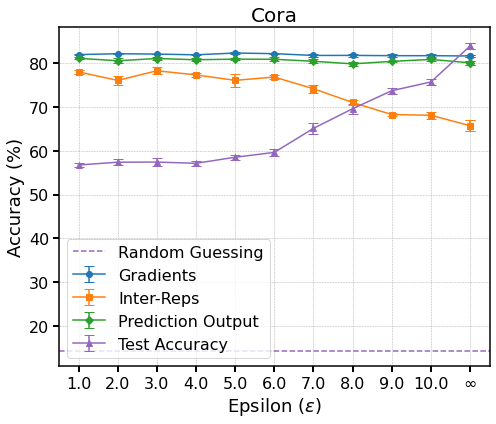

In [4]:
# Add data for no defense (epsilon = ∞)
no_defense_data = {
    'epsilon': 11, # ∞
    'Gradients_mean': 0.8171,
    'Gradients_sem': 0.0021,
    'Inter-Reps_mean': 0.6577,
    'Inter-Reps_sem': 0.0119,
    'Prediction Output_mean': 0.8014,
    'Prediction Output_sem': 0.0050,
    'test_accuracy_mean': 0.8397,
    'test_accuracy_sem': 0.0075
}

# Add no defense data to grouped_results
grouped_results = pd.concat([pd.DataFrame([no_defense_data]), grouped_results], ignore_index=True)
grouped_results = grouped_results.sort_values('epsilon', ascending=True)

# Plotting
plt.figure(figsize=(7, 6))
markers = ['o', 's', 'D', '^', 'v']  # Different marker shapes
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd']  # Different colors for each line
for i, attack in enumerate(['Gradients', 'Inter-Reps', 'Prediction Output', 'test_accuracy']): 
    mean_col = f'{attack}_mean'
    sem_col = f'{attack}_sem'
    label = 'Test Accuracy' if attack == 'test_accuracy' else attack
    plt.errorbar(grouped_results['epsilon'], grouped_results[mean_col]*100, yerr=grouped_results[sem_col]*100, 
                 label=label, capsize=5, marker=markers[i], color=colors[i])

# Add horizontal line for random guessing
plt.axhline(y=14.28, color='#9467bd', linestyle='--', label='Random Guessing')

plt.xlabel('Epsilon ($\epsilon$)', fontsize=18)
plt.ylabel('Accuracy (%)', fontsize=18)
plt.title('Cora', fontsize=20)
plt.legend(fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

#Set x-axis ticks to show all epsilon values including infinity
epsilon_values = list(grouped_results['epsilon'].unique())
epsilon_values[-1] = '∞'  # Replace inf with ∞ symbol
range_epsilon = range(1, len(epsilon_values)+1)


plt.xticks(range_epsilon, epsilon_values)

# print("X-axis ticks:")
# print(plt.gca().get_xticks())
# print("X-axis tick labels:")
# print(plt.gca().get_xticklabels())

# Increase tick font size and add more contrast
plt.tick_params(axis='both', which='major', labelsize=16, width=2, length=6)
plt.tick_params(axis='both', which='minor', labelsize=10, width=1, length=4)

# Add border to the figure
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

# Adjust x-axis to ensure epsilon 1 is visible
# plt.xlim(-0.5, len(epsilon_values) - 0.5)

plt.tight_layout()
# save the figure as pdf
plt.savefig('lapgraph_defense_cora.pdf', dpi=150)
plt.show()
